# Modelado de Tópicos en Tweets Políticos: Guía Práctica

## Objetivo de la Clase

En esta sesión práctica aprenderemos a aplicar modelado de tópicos para analizar discurso político en redes sociales, comparando dos enfoques principales: **LDA clásico** y **BERTopic moderno**.

**Caso de estudio**: Tweets de políticos colombianos para identificar agenda temática y evolución temporal.


# 1. Setup Rápido

In [ ]:
# Instalación (ejecutar una vez y reiniciar runtime)
!pip install scikit-learn matplotlib seaborn gensim wordcloud
!pip install bertopic sentence-transformers umap-learn hdbscan spacy
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

In [ ]:
# Importaciones esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# NLP y Topic Modeling
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from wordcloud import WordCloud

# Configuración
nlp = spacy.load('es_core_news_sm')
plt.style.use('default')
sns.set_palette("Set2")

print("✅ Setup completado")

✅ Setup completado


# 2. Carga y Preprocesamiento Rápido

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Clases/NLP para ciencias sociales/99. Datos/tweets_muestra_estratificada.csv'
df = pd.read_csv(file_path)
print(df.head())

                         id       politico                       fecha_raw  \
0  677f1f14782ccacddc4e6e35  Gustavo Petro  Tue Mar 24 19:44:38 +0000 2020   
1  677f1f13782ccacddc4e6a20  Gustavo Petro  Thu Mar 26 13:29:14 +0000 2020   
2  677f1f15782ccacddc4e72c7  Gustavo Petro  Wed Mar 11 00:17:32 +0000 2020   
3  677f1f14782ccacddc4e6e26  Gustavo Petro  Tue Mar 24 21:19:29 +0000 2020   
4  677f1f13782ccacddc4e672d  Gustavo Petro  Fri Mar 27 12:25:47 +0000 2020   

                                               texto  \
0  Existe en nuestra sociedad burbujas informativ...   
1  La evaluación del presidente de la asociación ...   
2  Solo dejando de emitir CO2 en todo el mundo se...   
3  Solo he hablado una vez con el presidente para...   
4  El confinamiento se prolongará al menos dos me...   

                       fecha     año  mes  año_mes  
0  2020-03-24 19:44:38+00:00  2020.0  3.0  2020-03  
1  2020-03-26 13:29:14+00:00  2020.0  3.0  2020-03  
2  2020-03-11 00:17:32+00:00  2020.

In [ ]:
# Preparar datos temporales si no existen o si la columna 'fecha' no es datetime
if 'fecha' not in df.columns:
    print("La columna 'fecha' no existe. Creando columna temporal...")
    # Create a placeholder if 'fecha' doesn't exist
    df['fecha'] = pd.date_range('2019-01-01', periods=len(df), freq='D')
else:
    # Ensure 'fecha' is datetime, coercing errors to NaT
    print("Convirtiendo la columna 'fecha' a datetime...")
    df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

# Drop rows where fecha is NaT after coercion, as they cannot be used for temporal analysis
df.dropna(subset=['fecha'], inplace=True)

# Now extract temporal components from the datetime column
df['año'] = df['fecha'].dt.year
df['mes'] = df['fecha'].dt.month
df['trimestre'] = df['fecha'].dt.quarter
df['año_trimestre'] = df['año'].astype(str) + '-Q' + df['trimestre'].astype(str)

print("Columnas temporales creadas o actualizadas.")

Convirtiendo la columna 'fecha' a datetime...
Columnas temporales creadas o actualizadas.


In [ ]:
print(f"Dataset: {len(df):,} tweets de {df['politico'].nunique()} políticos")
print(f"Período: {df['año_trimestre'].min()} - {df['año_trimestre'].max()}")

Dataset: 4,005 tweets de 4 políticos
Período: 2019-Q1 - 2024-Q3


### Preprocesamiento

In [ ]:
def procesar_tweet(texto):
    """Limpieza y procesamiento en una función"""
    if pd.isna(texto):
        return ""

    # Limpieza básica
    texto = texto.lower()
    texto = re.sub(r'http\S+|@\w+|#\w+|rt\s+', '', texto)  # URLs, menciones, hashtags, RTs
    texto = re.sub(r'[^\w\s]|\d+', ' ', texto)  # Puntuación y números
    texto = re.sub(r'\s+', ' ', texto).strip()

    # Procesamiento con spaCy
    doc = nlp(texto)
    tokens = [token.lemma_ for token in doc
              if not token.is_stop and token.is_alpha and len(token.text) > 2]

    return ' '.join(tokens)

# Aplicar preprocesamiento
print("Procesando textos...")
df['texto_procesado'] = df['texto'].apply(procesar_tweet)
df = df[df['texto_procesado'].str.len() > 15].copy()  # Filtrar textos muy cortos

print(f"✅ {len(df):,} tweets procesados y listos")

# Vista rápida
print("\n--- Ejemplo de preprocesamiento ---")
ejemplo = df.iloc[0]
print(f"Original: {ejemplo['texto'][:100]}...")
print(f"Procesado: {ejemplo['texto_procesado'][:100]}...")

Procesando textos...
✅ 3,897 tweets procesados y listos

--- Ejemplo de preprocesamiento ---
Original: Existe en nuestra sociedad burbujas informativas. Mucha gente aún no sabe que pasa en el mundo ni la...
Procesado: sociedad burbuja informativo gente pasar mundo gravedad virus escasez recurso ver comunicación distr...


# 3. LDA: Método Clásico

In [ ]:
# Vectorización TF-IDF
vectorizer = TfidfVectorizer(
    max_features=800,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 2)
)

tfidf_matrix = vectorizer.fit_transform(df['texto_procesado'])
print(f"Matriz TF-IDF: {tfidf_matrix.shape}")

Matriz TF-IDF: (3897, 800)


In [ ]:
# Entrenar LDA
n_topics = 6
lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    max_iter=10
)

lda_model.fit(tfidf_matrix)
print(f"✅ LDA entrenado con {n_topics} tópicos")

✅ LDA entrenado con 6 tópicos


In [ ]:
# Extraer tópicos principales
feature_names = vectorizer.get_feature_names_out()
print("\n--- Tópicos LDA ---")
for i, topic in enumerate(lda_model.components_):
    top_words = [feature_names[idx] for idx in topic.argsort()[-8:][::-1]]
    print(f"Tópico {i+1}: {' | '.join(top_words)}")

# Asignar tópicos a documentos
doc_topics = lda_model.transform(tfidf_matrix)
df['topico_lda'] = doc_topics.argmax(axis=1)
df['confianza_lda'] = doc_topics.max(axis=1)

print(f"\nDistribución de tópicos:")
print(df['topico_lda'].value_counts().sort_index())


--- Tópicos LDA ---
Tópico 1: país | gobierno | colombiano | nacional | seguridad | colombia | trabajo | proyecto
Tópico 2: solidaridad | familia | él | apoyo | carlos | luis | amigo | país
Tópico 3: mil | millón | año | colombia | mundo | vida | país | empleo
Tópico 4: colombia | metro | bogotá | pacto | histórico | país | pacto histórico | justicia
Tópico 5: él | petro | paz | pueblo | democracia | colombia | gobierno | violencia
Tópico 6: humano | colombia humano | colombia | candidato | salud | democrático | centro | alcaldía

Distribución de tópicos:
topico_lda
0    630
1    654
2    710
3    410
4    985
5    508
Name: count, dtype: int64


# 4. BERTopic: Transformers

In [ ]:
# Configuración simplificada
embedding_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

bertopic_model = BERTopic(
    embedding_model=embedding_model,
    nr_topics=None,  # Auto-detectar
    calculate_probabilities=True,
    verbose=False
)

# Entrenar (puede tomar unos minutos)
print("Entrenando BERTopic...")
topics, probs = bertopic_model.fit_transform(df['texto_procesado'].tolist())

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Entrenando BERTopic...


In [ ]:
# Asignar resultados
df['topico_bertopic'] = topics
if probs is not None and len(np.array(probs).shape) == 2:
    df['confianza_bertopic'] = np.max(probs, axis=1)
else:
    df['confianza_bertopic'] = probs if probs is not None else 0

# Mostrar resultados
n_topics_bert = len([t for t in set(topics) if t != -1])
n_outliers = sum(1 for t in topics if t == -1)

print(f"✅ BERTopic encontró {n_topics_bert} tópicos")
print(f"Outliers: {n_outliers:,} documentos ({n_outliers/len(df)*100:.1f}%)")

✅ BERTopic encontró 49 tópicos
Outliers: 1,355 documentos (34.8%)


In [ ]:
# Mostrar tópicos principales
print("\n--- Tópicos BERTopic ---")
topic_info = bertopic_model.get_topic_info()
for _, row in topic_info.head(6).iterrows():
    if row['Topic'] != -1:
        topic_words = bertopic_model.get_topic(row['Topic'])
        top_words = [word for word, _ in topic_words[:6]]
        print(f"Tópico {row['Topic']}: {' | '.join(top_words)}")


--- Tópicos BERTopic ---
Tópico 0: colombia | colombiano | humano | país | venezuela | paz
Tópico 1: acabar | uribir | gracias | medellín | casa | don
Tópico 2: deuda | crédito | billón | tributario | déficit | banco
Tópico 3: cocaína | droga | consumo | coca | marihuana | narcotráfico
Tópico 4: solidaridad | familia | fallecer | fallecimiento | gratitud | familiar


# 5. Comparación Visual Rápida

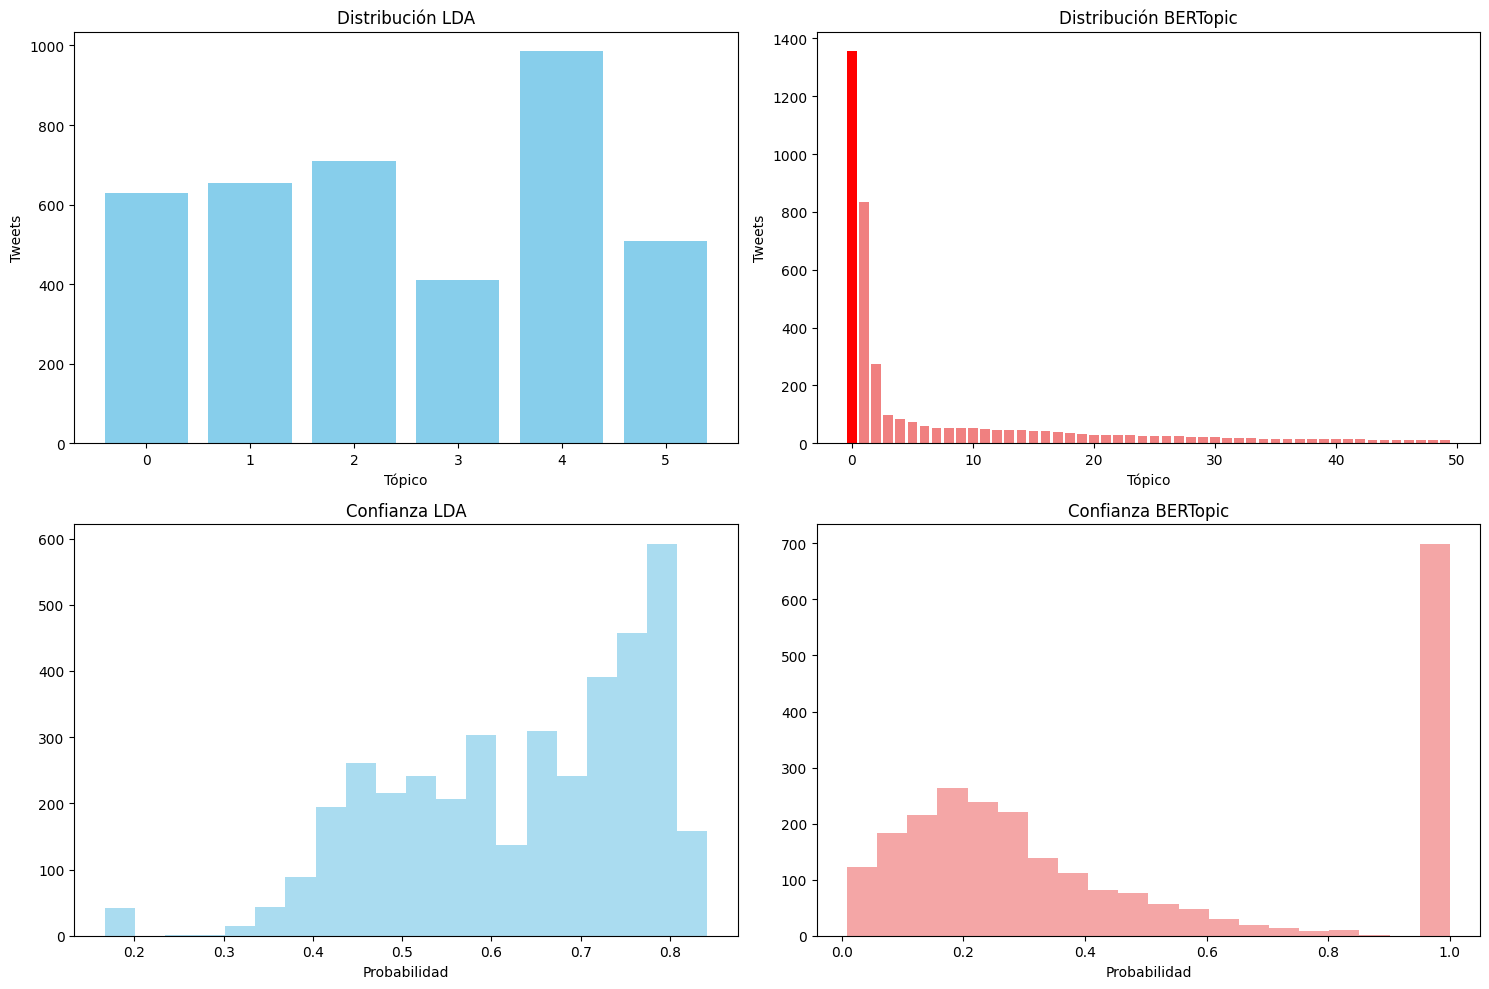

In [ ]:
# Setup de gráficos
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribución de tópicos LDA
ax1 = axes[0, 0]
lda_dist = df['topico_lda'].value_counts().sort_index()
ax1.bar(range(len(lda_dist)), lda_dist.values, color='skyblue')
ax1.set_title('Distribución LDA')
ax1.set_xlabel('Tópico')
ax1.set_ylabel('Tweets')

# 2. Distribución de tópicos BERTopic
ax2 = axes[0, 1]
bert_dist = df['topico_bertopic'].value_counts().sort_index()
colors = ['red' if t == -1 else 'lightcoral' for t in bert_dist.index]
ax2.bar(range(len(bert_dist)), bert_dist.values, color=colors)
ax2.set_title('Distribución BERTopic')
ax2.set_xlabel('Tópico')
ax2.set_ylabel('Tweets')

# 3. Confianza LDA
ax3 = axes[1, 0]
ax3.hist(df['confianza_lda'], bins=20, alpha=0.7, color='skyblue')
ax3.set_title('Confianza LDA')
ax3.set_xlabel('Probabilidad')

# 4. Confianza BERTopic
ax4 = axes[1, 1]
if df['confianza_bertopic'].max() > 0:
    valid_conf = df[df['topico_bertopic'] != -1]['confianza_bertopic']
    ax4.hist(valid_conf, bins=20, alpha=0.7, color='lightcoral')
ax4.set_title('Confianza BERTopic')
ax4.set_xlabel('Probabilidad')

plt.tight_layout()
plt.show()

In [ ]:
# Tabla comparativa
print("\n--- Comparación Cuantitativa ---")
comparison = pd.DataFrame({
    'Métrica': ['Tópicos', 'Cobertura (%)', 'Confianza Media'],
    'LDA': [
        n_topics,
        100.0,
        f"{df['confianza_lda'].mean():.3f}"
    ],
    'BERTopic': [
        n_topics_bert,
        f"{((len(df) - n_outliers)/len(df)*100):.1f}",
        f"{df[df['topico_bertopic'] != -1]['confianza_bertopic'].mean():.3f}"
    ]
})
print(comparison.to_string(index=False))


--- Comparación Cuantitativa ---
        Métrica    LDA BERTopic
        Tópicos      6       49
  Cobertura (%)  100.0     65.2
Confianza Media  0.633    0.468


# 6. Análisis Aplicado: Insights Políticos

In [ ]:
# 1. Especialización temática por político
print("--- Especialización Temática ---")
for politico in df['politico'].value_counts().head(3).index:
    pol_data = df[df['politico'] == politico]
    topico_principal = pol_data['topico_lda'].mode().iloc[0]
    concentracion = (pol_data['topico_lda'] == topico_principal).mean() * 100

    print(f"{politico}: {concentracion:.1f}% en Tópico {topico_principal + 1} ({len(pol_data)} tweets)")

--- Especialización Temática ---
Gustavo Petro: 31.2% en Tópico 5 (1328 tweets)
Álvaro Uribe: 26.9% en Tópico 2 (904 tweets)
Gustavo Bolívar: 40.7% en Tópico 5 (863 tweets)



--- Evolución Temporal ---


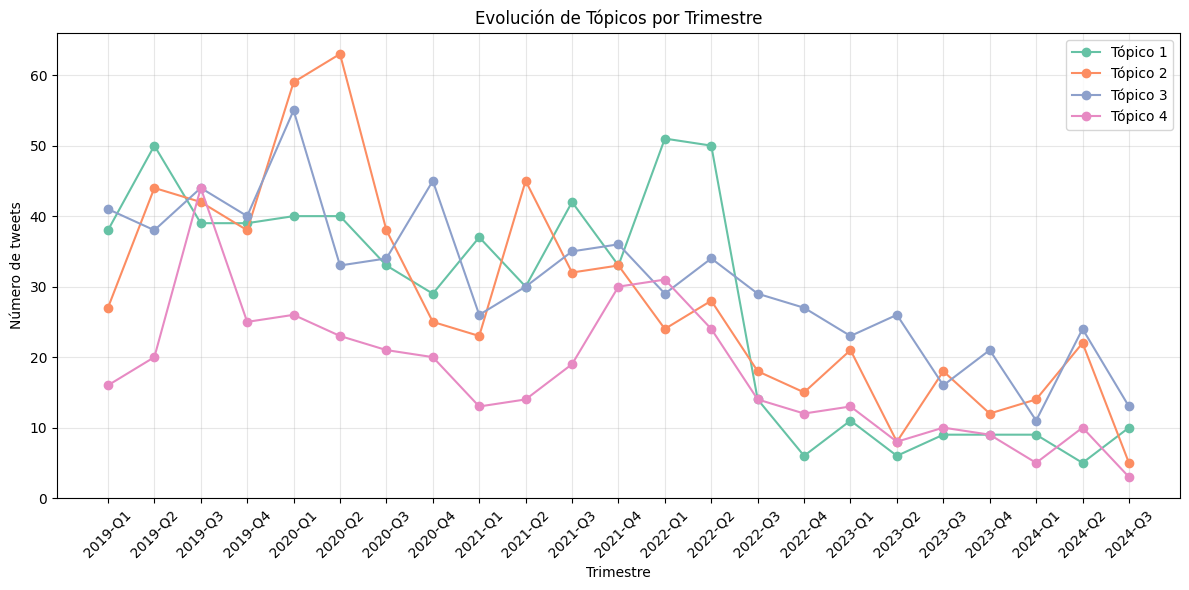

In [ ]:
# 2. Evolución temporal (últimos trimestres)
print("\n--- Evolución Temporal ---")
evolucion = df.groupby(['año_trimestre', 'topico_lda']).size().unstack(fill_value=0)

# Gráfico de evolución
plt.figure(figsize=(12, 6))
for topico in range(min(4, n_topics)):
    plt.plot(evolucion.index, evolucion[topico], marker='o', label=f'Tópico {topico+1}')

plt.title('Evolución de Tópicos por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Número de tweets')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 3. Detección de eventos (cambios bruscos)
print("\n--- Detección de Eventos ---")
for topico in range(n_topics):
    serie = evolucion[topico]
    cambios = serie.pct_change().fillna(0)
    eventos_significativos = cambios[abs(cambios) > 1.0]  # Cambios >100%

    if len(eventos_significativos) > 0:
        print(f"Tópico {topico + 1} - Eventos detectados:")
        for periodo, cambio in eventos_significativos.items():
            direccion = "📈" if cambio > 0 else "📉"
            print(f"  {periodo}: {direccion} {abs(cambio)*100:.0f}% cambio")


--- Detección de Eventos ---
Tópico 2 - Eventos detectados:
  2023-Q3: 📈 125% cambio
Tópico 3 - Eventos detectados:
  2024-Q2: 📈 118% cambio
Tópico 4 - Eventos detectados:
  2019-Q3: 📈 120% cambio
Tópico 6 - Eventos detectados:
  2023-Q1: 📈 133% cambio


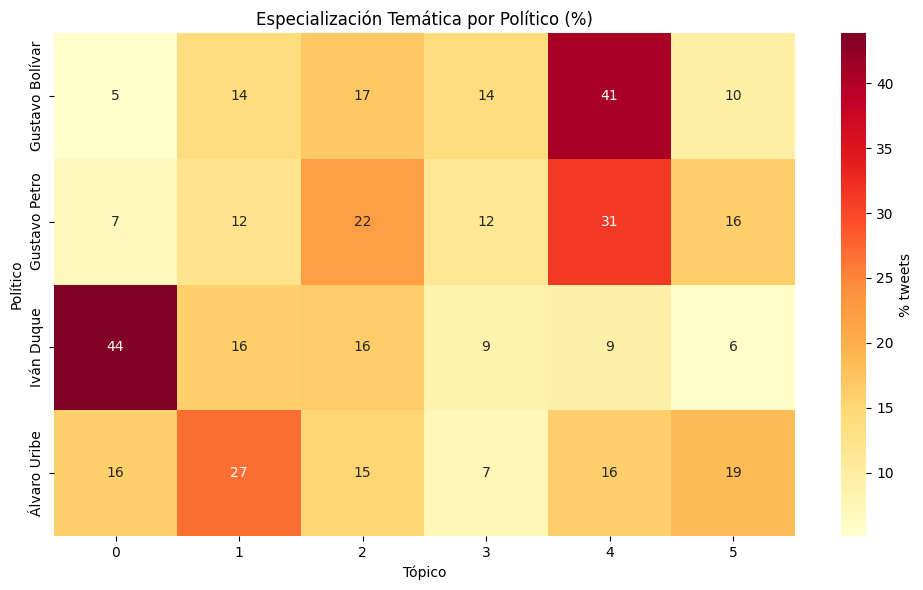

In [ ]:
# 4. Mapa de calor político-temático
plt.figure(figsize=(10, 6))
heatmap_data = df.groupby(['politico', 'topico_lda']).size().unstack(fill_value=0)
heatmap_norm = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) * 100

sns.heatmap(heatmap_norm, annot=True, fmt='.0f', cmap='YlOrRd',
            cbar_kws={'label': '% tweets'})
plt.title('Especialización Temática por Político (%)')
plt.xlabel('Tópico')
plt.ylabel('Político')
plt.tight_layout()
plt.show()

# 7. Interpretación y Casos de Uso

In [ ]:
# Identificar tópicos más interpretables
print("--- Calidad de Tópicos ---")
for topico in range(n_topics):
    docs_topico = df[df['topico_lda'] == topico]
    confianza_media = docs_topico['confianza_lda'].mean()
    diversidad_politicos = docs_topico['politico'].nunique()
    diversidad_temporal = docs_topico['año_trimestre'].nunique()

    calidad = "Alta" if confianza_media > 0.4 and diversidad_politicos > 1 else "Media" if confianza_media > 0.3 else "Baja"

    print(f"Tópico {topico + 1}: {calidad} calidad")
    print(f"  Confianza: {confianza_media:.3f}")
    print(f"  Políticos diversos: {diversidad_politicos}/{df['politico'].nunique()}")
    print(f"  Períodos diversos: {diversidad_temporal}/{df['año_trimestre'].nunique()}")

print(f"\n--- Casos de Uso Identificados ---")
print(f"""
🎯 APLICACIONES PRÁCTICAS:

1. MONITOREO DE AGENDA POLÍTICA:
   • Seguir evolución de temas en tiempo real
   • Identificar nuevos issues emergentes
   • Comparar agendas entre partidos/candidatos

2. ANÁLISIS DE COMUNICACIÓN:
   • Medir especialización temática de políticos
   • Detectar cambios estratégicos en messaging
   • Identificar oportunidades de diferenciación

3. INVESTIGACIÓN ACADÉMICA:
   • Estudiar polarización temática
   • Analizar respuesta a eventos externos
   • Validar teorías de agenda-setting

4. CONSULTORÍA POLÍTICA:
   • Benchmark contra competencia
   • Optimizar estrategia de contenido
   • Detectar gaps temáticos

RECOMENDACIONES METODOLÓGICAS:
• LDA: Mejor para análisis exploratorio y comparaciones sistemáticas
• BERTopic: Superior para análisis semántico profundo y detección de outliers
• Combinar ambos métodos para validación cruzada
""")

--- Calidad de Tópicos ---
Tópico 1: Alta calidad
  Confianza: 0.602
  Políticos diversos: 4/4
  Períodos diversos: 23/23
Tópico 2: Alta calidad
  Confianza: 0.644
  Políticos diversos: 4/4
  Períodos diversos: 23/23
Tópico 3: Alta calidad
  Confianza: 0.644
  Políticos diversos: 4/4
  Períodos diversos: 23/23
Tópico 4: Alta calidad
  Confianza: 0.626
  Políticos diversos: 4/4
  Períodos diversos: 23/23
Tópico 5: Alta calidad
  Confianza: 0.639
  Políticos diversos: 4/4
  Períodos diversos: 23/23
Tópico 6: Alta calidad
  Confianza: 0.634
  Políticos diversos: 4/4
  Períodos diversos: 23/23

--- Casos de Uso Identificados ---

🎯 APLICACIONES PRÁCTICAS:

1. MONITOREO DE AGENDA POLÍTICA:
   • Seguir evolución de temas en tiempo real
   • Identificar nuevos issues emergentes
   • Comparar agendas entre partidos/candidatos

2. ANÁLISIS DE COMUNICACIÓN:
   • Medir especialización temática de políticos
   • Detectar cambios estratégicos en messaging
   • Identificar oportunidades de diferenci